In [1]:
import sys
sys.path.append('./imagenette-KAN/src')
from efficient_kan.kan import KAN

# Train on imagenette
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv

In [5]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
trainset = torchvision.datasets.Imagenette(
    root="./data", split="train", transform=transform,
    # download=True
)
valset = torchvision.datasets.Imagenette(
    root="./data", split="val", transform=transform,
    # download=True
)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)


In [6]:

# Define model
input_size = 256 * 256 * 3
model = KAN([input_size, 64, 10])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Define loss
criterion = nn.CrossEntropyLoss()

In [7]:
train_losses = []
val_losses = []
val_accuracies = []

In [10]:
with open('imagenette_KAN.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Loss", "Accuracy"])

    for epoch in range(10):
        # Train
        model.train()
        train_loss = 0
        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, input_size).to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
        train_loss /= len(trainloader)
        # Validation
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for images, labels in valloader:
                images = images.view(-1, input_size).to(device)
                output = model(images)
                val_loss += criterion(output, labels.to(device)).item()
                val_accuracy += (
                    (output.argmax(dim=1) == labels.to(device)).float().mean().item()
                )
        val_loss /= len(valloader)
        val_accuracy /= len(valloader)

        # Save results for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        writer.writerow([epoch, val_loss, val_accuracy])

        # Update learning rate
        scheduler.step()

        print(
            f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
        )


100%|██████████| 148/148 [01:12<00:00,  2.04it/s, accuracy=0.197, loss=2.22, lr=0.001]


Epoch 1, Val Loss: 2.1518272430666032, Val Accuracy: 0.21688988131861534


100%|██████████| 148/148 [01:03<00:00,  2.35it/s, accuracy=0.311, loss=2.09, lr=0.0008]


Epoch 2, Val Loss: 1.9985960510469252, Val Accuracy: 0.3118639593162844


100%|██████████| 148/148 [00:57<00:00,  2.58it/s, accuracy=0.525, loss=1.47, lr=0.00064]


Epoch 3, Val Loss: 1.8939349997428157, Val Accuracy: 0.3635152650456275


100%|██████████| 148/148 [00:57<00:00,  2.58it/s, accuracy=0.443, loss=1.47, lr=0.000512]


Epoch 4, Val Loss: 1.8450193972356859, Val Accuracy: 0.40032162060660703


100%|██████████| 148/148 [00:57<00:00,  2.58it/s, accuracy=0.541, loss=1.32, lr=0.00041]


Epoch 5, Val Loss: 1.891421805466375, Val Accuracy: 0.40790610640279706


100%|██████████| 148/148 [00:57<00:00,  2.56it/s, accuracy=0.525, loss=1.32, lr=0.000328]


Epoch 6, Val Loss: 1.9052789845774252, Val Accuracy: 0.42677131343272423


100%|██████████| 148/148 [00:57<00:00,  2.56it/s, accuracy=0.607, loss=1.05, lr=0.000262] 


Epoch 7, Val Loss: 1.9013065811126464, Val Accuracy: 0.4159586218095595


100%|██████████| 148/148 [00:58<00:00,  2.53it/s, accuracy=0.721, loss=0.834, lr=0.00021]


Epoch 8, Val Loss: 1.8729363410703597, Val Accuracy: 0.4308155722195102


100%|██████████| 148/148 [00:59<00:00,  2.48it/s, accuracy=0.689, loss=0.902, lr=0.000168]


Epoch 9, Val Loss: 1.92141895140371, Val Accuracy: 0.4363599270582199


100%|██████████| 148/148 [01:01<00:00,  2.41it/s, accuracy=0.738, loss=0.827, lr=0.000134]


Epoch 10, Val Loss: 1.955250616996519, Val Accuracy: 0.42955549157434897


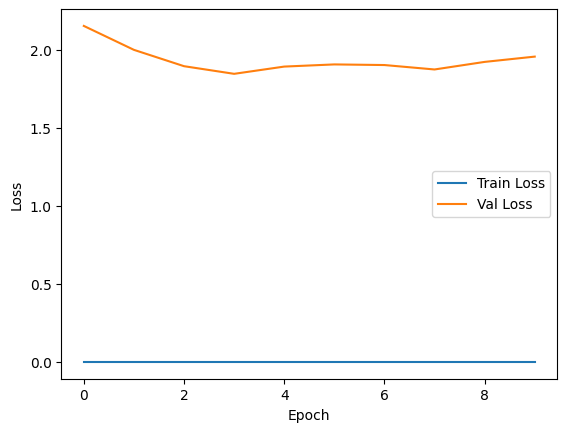

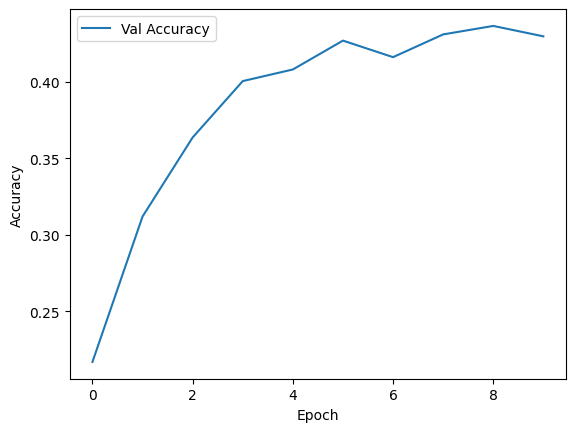

In [11]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()